In [40]:
#General Packages
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import ipyparallel as ipp
plt.style.use('classic')

import pennylane as qml

#Qiskit packages
import qiskit
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, ADAM, SLSQP, GradientDescent
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import I, X, Y, Z, Zero, One, PauliExpectation, CircuitSampler, StateFn, DictStateFn, CircuitStateFn, NaturalGradient

In [45]:
class RandomIsing:
    """
    Stores the information of a model, which is defined by Ising bonds (J) on a 
    graph (G) with a parallel field (h).
    """
    def __init__(self,d,nqubits,localTerm=True):
        """
        d < n 
        d*n even
        """
        self.d = d
        self.nqubits = nqubits
        self.localTerm = localTerm

        self.G = nx.random_regular_graph(d,nqubits)
        self.J = {pair: 2*np.random.randint(2)-1 for pair in list(self.G.edges())}
        
        if localTerm:
            self.h = 2*np.random.randint(2,size=self.nqubits)-1
        else:
            self.h = np.zeros(self.nqubits)

    def drawGraph(self):
        return nx.draw(self.G, with_labels=True, alpha=0.8, node_size=500)

    def setCoupling(self,J):
        for pair in list(self.G.edges()):
            self.J.update({pair:J})

    
    def Hamiltonian(self):
        H = I^self.nqubits
        for pair in list(self.G.edges()):
            H += self.J.get(pair)*((I^pair[0])^Z^(I^(self.nqubits-pair[0]-1)))@((I^pair[1])^Z^(I^(self.nqubits-pair[1]-1)))
        for i in range(self.nqubits):
            H += self.h[i]*((I^i)^Z^(I^(self.nqubits-i-1)))
        H -= I^self.nqubits
        return H.reduce()
    
    """
    def QAOA_gd(self, p, record=True):
        #returns optimization result of QAOA and the QAOA instance
        callback = None
        if record:
            self.callback = callback
        solver = QAOA(GradientDescent(maxiter=50000, learning_rate=0.01), reps=p, quantum_instance=QuantumInstance(Aer.get_backend('statevector_simulator')),initial_point=np.append(np.linspace(2,0.1,p),np.linspace(0.5,2.5,p)),callback=callback)
        res = solver.compute_minimum_eigenvalue(self.Hamiltonian())
        if res.cost_function_evals >= 50000:
            print('not converged',res)
        return res, solver
    """
    def QAOA(self, p, record=False):
        """returns optimization result of QAOA and the QAOA instance"""
        callback = None
        if record:
            callback = self.callback
        solver = QAOA(COBYLA(maxiter=50000),reps=p,quantum_instance=QuantumInstance(Aer.get_backend('statevector_simulator')),initial_point=np.append(np.linspace(2,0.1,p),np.linspace(0.5,2.5,p)),callback=callback)
        res = solver.compute_minimum_eigenvalue(self.Hamiltonian())
        if res.cost_function_evals >= 50000:
            print('not converged',res)
        return res, solver

    def test(self):
        dev= qml.device("default.qubit", wires= self.nqubits)


def Plotting(x_data, y_data, y_err,  x_label, y_label,title, type):
    fig,ax = plt.subplots()
    ax.errorbar(x_data, y_data, yerr= y_err, marker="o", ls="")
    if len(title)!= 0:
        ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid()
    if type== "normal_order":
        ax.set_xlim(x_data[0]-1/2, x_data[-1]+1/2)
    else:
       ax.set_xlim(x_data[-1]-1/2, x_data[0]+1/2)
        


def ApproximateRatio(d, nqubits,p):
    mod= RandomIsing(d,nqubits,localTerm=True)
    np_me= NumPyMinimumEigensolver()
    res_np= np_me.compute_minimum_eigenvalue(operator= mod.Hamiltonian())
    res , solver = mod.QAOA(p)  #depth of system 
    E0= res_np.eigenvalue.real
    return  res.eigenvalue.real/E0, solver, res
        

## Part A
Approximate Ratio as a function of the number of fully connected qubits:

In [47]:
#nqubits= [i+1 for i in range(3,10)]
#d= [ i-1 for i in nqubits]          #connectivity
nqubits=[5]
d=4

sample_size= 10
p= 1 #depth of system - constant for part a) and b)

r , solver, res = np.zeros((len(nqubits), sample_size)), np.zeros((len(nqubits), sample_size)) , np.zeros((len(nqubits), sample_size))

for i in range(len(nqubits)):
    for j in range(sample_size):
            r[i][j] , solver, res = ApproximateRatio(d,nqubits[i],p)    

r_mean= np.mean(r, axis=1)
r_std= np.std(r, axis=1 , ddof=1)


In [37]:
print(res)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 843,
    'eigenstate': array([ 3.88427594e-04+2.65982693e-05j, -1.72371634e-04-2.13065652e-04j,
        6.67564059e-05-8.76092040e-05j, -7.67877553e-05+9.75301062e-05j,
        1.63010588e-02-3.47348479e-02j, -9.79545578e-05-4.03287977e-04j,
       -4.79938135e-04+1.69838930e-04j,  2.57668999e-04+1.51609997e-05j,
        1.22927494e-03+7.46245659e-03j,  2.81463512e-04+3.65994540e-04j,
        2.78836528e-04+1.53653379e-04j, -2.43738489e-04+1.86063463e-04j,
        6.78651425e-02+9.96324247e-01j,  1.07589089e-04-8.24423801e-03j,
        5.41616064e-03-2.31603135e-02j, -1.46576234e-04+6.91061537e-04j,
        6.67564059e-05-8.76092040e-05j, -7.67877553e-05+9.75301062e-05j,
       -3.97903812e-04-2.40451079e-04j, -4.10977448e-05+1.18493949e-04j,
       -4.79938135e-04+1.69838930e-04j,  2.57668999e-04+1.51609997e-05j,
       -1.73158807e-05+3.48830647e-04j,  1.69123611e-05+1.14343896e-04j,
        2.78836528e-04+1.53653379e-0

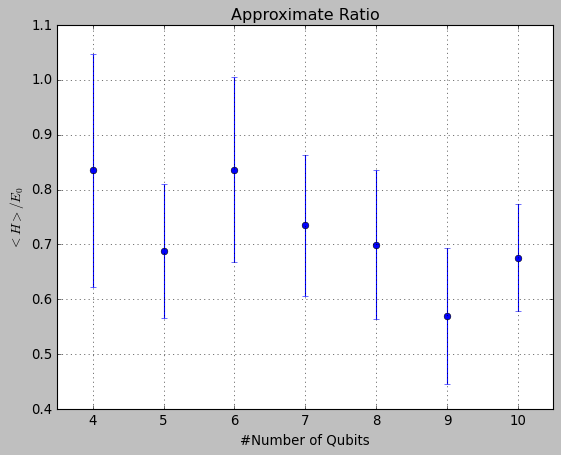

In [34]:
Plotting(nqubits,r_mean, r_std, "#Number of Qubits", "$ <H>/E_0$" ,"Approximate Ratio","normal_order")
plt.show()

In [39]:
#print(r)
#print(r_mean)
#print(r_std)

## Part B
Approximate Ratio as a function of connectivity

In [36]:
nqubit_indv= 8
d_indv= [ nqubit_indv-(i+1) for i in range(5)]

r= np.zeros((len(d_indv),sample_size))


for i in range(len(d_indv)):
    for j in range(sample_size):
            #print(d_indv[i])
            r[i][j] = ApproximateRatio(d_indv[i],nqubit_indv,p)    


r_indv_mean= np.mean(r, axis=1)
r_indv_std= np.std(r, axis=1 , ddof=1)


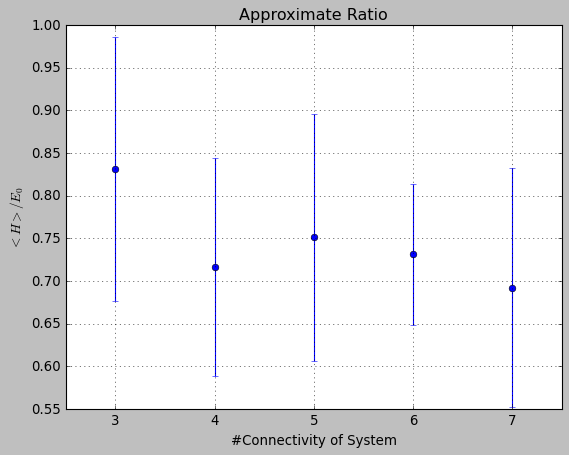

In [56]:
Plotting(d_indv,r_indv_mean, r_indv_std, "#Connectivity of System", "$ <H>/E_0$" ,"Approximate Ratio", "inverse_order")
plt.show()

## Part C
For a fully connected 5-Qubit system, the r-value as a function of the circuit depth can be caluclated in:

In [48]:
nqubit= 5
d= 4
p= [i+1 for i in range(7)] 
sample_size= 10

r= np.zeros((len(p),sample_size))

for i in p:
    for j in range(sample_size):
            r[i-1][j] = ApproximateRatio(d,nqubit,i)    


r_con_mean= np.mean(r, axis=1)
r_con_std= np.std(r, axis=1 , ddof=1)

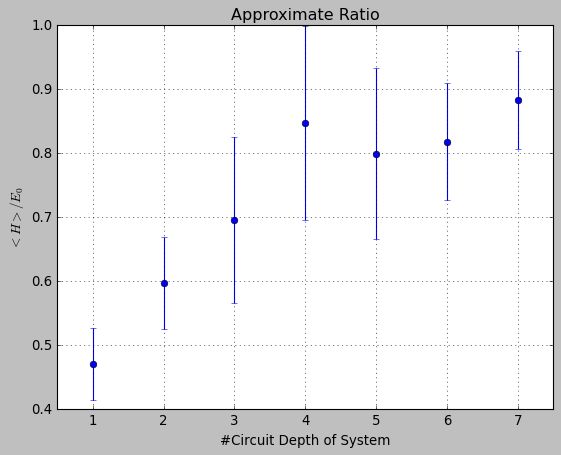

In [55]:
Plotting(p,r_con_mean, r_con_std, "#Circuit Depth of System", "$ <H>/E_0$" ,"Approximate Ratio", "normal")
plt.show()

In [51]:
print(p)
print(r_con_mean)

[1, 2, 3, 4, 5, 6, 7]
[0.46990391 0.59732772 0.69509602 0.84660045 0.79908307 0.81753337
 0.88306126]
